#### 引入庫

In [15]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, cross_validate

#### 資料查看以及資料處理

資料讀取

In [16]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print("Train Data Size:", train.shape)
print("Test Data Size:", test.shape)

Train Data Size: (8693, 14)
Test Data Size: (4277, 13)


In [17]:
print("Train First 5 Elements:")
train.head()

Train First 5 Elements:


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [18]:
print("Test First 5 Elements:")
test.head()

Test First 5 Elements:


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


查看缺失值

In [19]:
print('Train Set Missing Values:')
print(train.isna().sum())
print('')
print('Test Set Missing Values:')
print(test.isna().sum())

Train Set Missing Values:
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

Test Set Missing Values:
PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


查看資料類型

In [20]:
train.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

查看資料分布

Text(0.5, 1.0, 'Target Distribution')

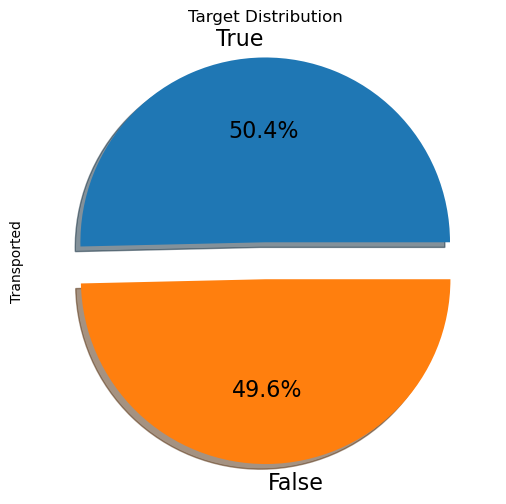

In [21]:
plt.figure(figsize=(6,6))

# Pie plot
train['Transported'].value_counts().plot.pie(
    explode=[0.1,0.1], autopct='%1.1f%%', shadow=True,
    textprops={'fontsize':16}).set_title("Target Distribution")

#### 資料前處理

##### 處理缺失值

In [22]:
imputer_cols = ["Age", "FoodCourt", "ShoppingMall", "Spa", "VRDeck" ,"RoomService"]
imputer = SimpleImputer(strategy='median' )
imputer.fit(train[imputer_cols])
train[imputer_cols] = imputer.transform(train[imputer_cols])
test[imputer_cols] = imputer.transform(test[imputer_cols])
train["HomePlanet"].fillna('Z', inplace=True)
test["HomePlanet"].fillna('Z', inplace=True)

##### 將非數值特徵轉換為數值

In [23]:
str_label_cols = ["HomePlanet", "CryoSleep", "Cabin", "Destination", "VIP"]
def label_encoder(train,test,columns):
    for col in columns:
        train[col] = train[col].astype(str)
        test[col] = test[col].astype(str)
        train[col] = LabelEncoder().fit_transform(train[col])
        test[col] =  LabelEncoder().fit_transform(test[col])
    return train, test

train, test = label_encoder(train, test, str_label_cols)

In [24]:
train.drop(["Name" ,"Cabin"] , axis = 1 ,inplace = True)
test.drop(["Name" ,"Cabin"] , axis = 1 ,inplace = True)
X = train.drop("Transported", axis=1)
y = train["Transported"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2,
                                                    train_size=0.8, test_size=0.2)

#### 訓練模型
##### 定義共用的可視化函數
* ROC Curve：
ROC曲線使用TP(True Positive)跟FN(False Negative)來對分類器做比較
<br>
<img src="https://cdn.discordapp.com/attachments/838726124775145493/1227631136700633149/image.png?ex=66291b97&is=6616a697&hm=3b81f45566b2867786d3ffd5472694d50c9725d592a6cc5541ca7cb80aa20143&" width="300">
<br>
<img src="https://media.discordapp.net/attachments/838726124775145493/1227629996068307024/image.png?ex=66291a87&is=6616a587&hm=f9da423ea912f60705d74d8e06341adf02a8fa2620c637cbb7f058495d7d4428&=&format=webp&quality=lossless&width=902&height=676" width="400">
* AUC(Area Under Curve)：
在比較不同的分類模型時，可以將每個模型的ROC曲線都畫出來，比較曲線下面積做為模型優劣的指標(\*ROC Curve越往左上 => AUC 越大，模型在解決這個問題的正確率越高)。

In [25]:
def model_report(y_test, y_test_pred):
    conf_matrix = confusion_matrix(y_test, y_test_pred)

    # 生成分類報告
    class_report = classification_report(y_test, y_test_pred)

    # 計算 ROC Curve 和 AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
    roc_auc = auc(fpr, tpr)

    # Visualize Confusion Matrix
    plt.figure(figsize=(5,3))
    sns.heatmap(conf_matrix, annot=True)
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()

    # 輸出分類報告
    print("Classification Report:")
    print(class_report)

    # Visualize ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

##### K-Nearest Neighbor(KNN)

In [26]:
# hyperparameter
knn_param_grid = {'n_neighbors':[1,3,5,7,9],
                  'p': [1, 2]}

knn_gs = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=knn_param_grid,
                      refit=True, scoring = 'accuracy',
                      cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=12))

knn_gs.fit(X_train, y_train)
y_test_pred = knn_gs.predict(X_test)

(1739,)


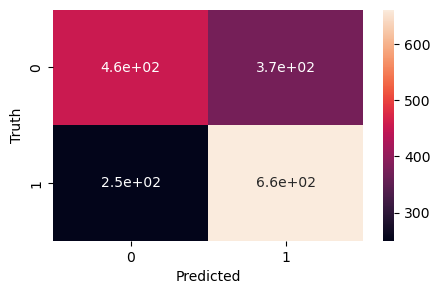

Classification Report:
              precision    recall  f1-score   support

       False       0.65      0.55      0.59       828
        True       0.64      0.73      0.68       911

    accuracy                           0.64      1739
   macro avg       0.64      0.64      0.64      1739
weighted avg       0.64      0.64      0.64      1739



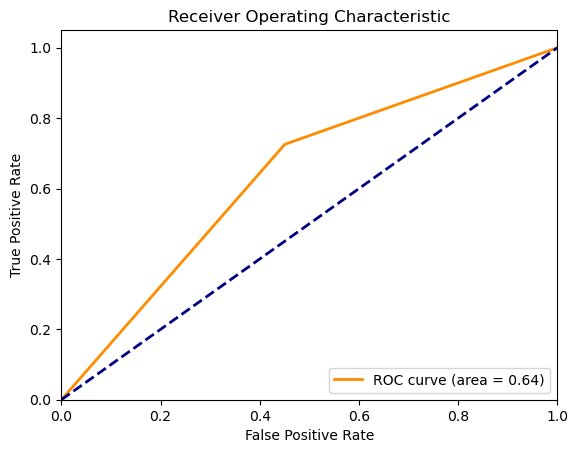

In [27]:
print(y_test_pred.shape)
model_report(y_test, y_test_pred)

##### 隨機森林(Random Forest Classifier)

In [28]:
rf_param_grid = {'n_estimators': [50, 100, 150, 200, 250, 300],
                'max_depth': [4, 6, 8, 10, 12, 14]}

rf_gs = GridSearchCV(estimator=RandomForestClassifier(), param_grid=rf_param_grid,
                    refit=True, scoring='accuracy',
                    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=12))

rf_gs.fit(X_train, y_train)
y_test_pred = rf_gs.predict(X_test)

(1739,)


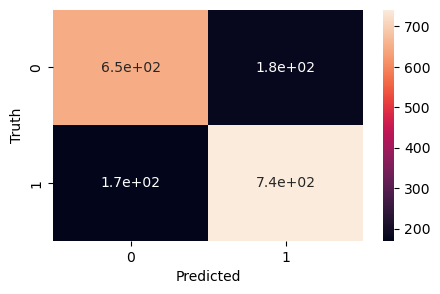

Classification Report:
              precision    recall  f1-score   support

       False       0.79      0.78      0.79       828
        True       0.80      0.81      0.81       911

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739



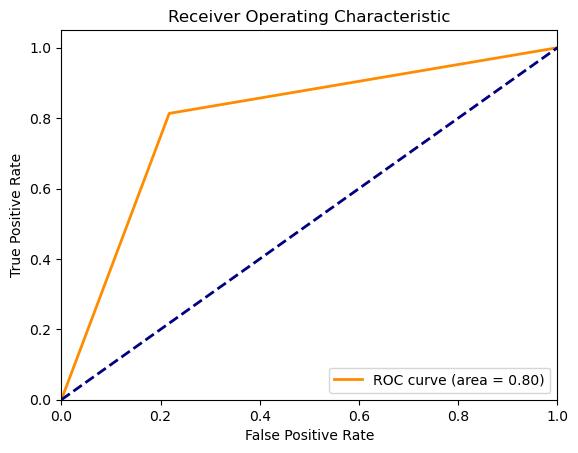

In [29]:
print(y_test_pred.shape)
model_report(y_test, y_test_pred)

##### Support Vector Classifier(SVC)

In [ ]:
# hyperparameter
svc_param_grid = {'C':[0.25, 0.5, 0.75, 1, 1.25, 1.5]}

svc_gs = GridSearchCV(estimator=SVC(), param_grid=svc_param_grid,
                     refit=True, scoring='accuracy',
                     cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=12))

svc_gs.fit(X_train, y_train)
y_test_pred = svc_gs.predict(X_test)

In [ ]:
print(y_test_pred.shape)
model_report(y_test, y_test_pred)